In [24]:
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import multiprocessing as mp
from PIL import Image

sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from dataset_simulation import DatasetSimulation

class DatasetYolo(DatasetSimulation):
    
    # Initializer
    def __init__(self, dataset_sim_location, t_res, f_res):
        super().__init__(dataset_sim_location, t_res, f_res)
    
    def whistler_group_sim(self, An, D0, d0, k, magnitude):
        '''Simulate a group of whistler by varying the zero dispersion
        Params
            An: normalised equatorial electron gyrofrequency
            D0: zero dispersion
            d0: additional zero dispersion
            k: number of whistlers with dispersion ranging from D0 to D0+d0
            magnitude: magnitude in dB of the whistler
        Return
            whistler data
        '''
        D = np.linspace(D0,D0+d0,k)
        data = []
        t_size, f_size = 0,0
        for d in D:
            whistler = self.whistler_sim(An, d, magnitude)
            data.append(whistler)
            if t_size <= whistler.shape[1]:
                t_size = whistler.shape[1]
                f_size = whistler.shape[0]
        whistler_data = np.zeros((f_size, t_size))
        for d in data:
            whistler_data[:d.shape[0], -d.shape[1]:] += d
        for f in range(f_size):
            for t in range(t_size):
                whistler_data[f,t] = magnitude if whistler_data[f,t]>= magnitude else 0 
        return whistler_data
    
    def yolo_sim(self, An, D0, d0, k, magnitude, mean, std):
        '''Simulate a group of whistler by varying the zero dispersion
        Params
            An: normalised equatorial electron gyrofrequency
            D0: zero dispersion
            d0: additional zero dispersion
            k: number of whistlers with dispersion ranging from D0 to D0+d0
            magnitude: magnitude in dB of the whistler
            mean: mean of the noise
            std: standard deviation of the noise
        Return
            data: whistler data
            labels: yolo labels of the data
        '''
        f_max, t_max = 20e3, 3
        f = np.linspace(0,f_max,int(f_max*1e-3/self.get_freq_res()))
        t = np.linspace(0,t_max,int(t_max/self.get_time_res()))
        t_size, f_size = len(t), len(f)
        # create noise background
        data = np.random.normal(mean, std, f_size*t_size)
        data = data.reshape(f_size,t_size)
        # generate whistler
        whistler = self.whistler_group_sim(An, D0, d0, k, magnitude)
        whistler_freq, whistler_time = whistler.shape
        # position whistler randomly in the data
        whistler_t_start = np.random.randint(0,t_size-whistler_time)
        whistler_f_start = int(1/self.get_freq_res())
        x1,y1,x2,y2 = whistler_t_start, whistler_f_start, whistler_time+whistler_t_start, whistler_freq+whistler_f_start 
        data[y1:y2, x1:x2]+= whistler
        # get yolo labels 
        # class, x_start, y_start, x_end, y_end, x_center, y_center, width, height
        labels = []
        # for whistler
        labels.append([1, abs(x2+x1)/(2*t_size), abs(y2+y1)/(2*f_size), abs(x2-x1)/t_size, abs(y2-y1)/f_size])
        # for fisrt noise
        x1,y1,x2,y2 = 0, 0, whistler_t_start, whistler_f_start
        labels.append([0, abs(x2+x1)/(2*t_size), abs(y2+y1)/(2*f_size), abs(x2-x1)/t_size, abs(y2-y1)/f_size])
        # for last noise
        x1,y1,x2,y2 = whistler_time+whistler_t_start, whistler_freq+whistler_f_start, t_size-1, f_size-1
        labels.append([0, abs(x2+x1)/(2*t_size), abs(y2+y1)/(2*f_size), abs(x2-x1)/t_size, abs(y2-y1)/f_size])
        return data, labels
    
    def yolo_sim_file(self, An, D0, d0, k, magnitude, mean, std):
        """Generate a yolo simulated data and save it"""
        An = np.round(An,4)
        D0 = np.round(D0,2)
        d0 = np.round(d0,0)
        k = np.round(k,0)
        magnitude = np.round(magnitude,2)
        mean, std = np.round(mean,3), np.round(std,3)
        data, labels = self.yolo_sim(An=An, D0=D0, d0=d0, k=k, magnitude=magnitude, mean=mean, std=std)
        a,d,d0,k,m,fn,f_min,f_max = str(An), str(D0), str(d0), str(k), str(magnitude),str(int(self.get_fn())), str(int(self.get_frequency_range().min())), str(int(self.get_frequency_range().max()))
        u,s = str(mean), str(std)
        file_name = os.path.join(os.path.join(self.get_location(),'data'), a+'_'+d+'_'+d0+'_'+k+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+'_'+u+'_'+s+'.jpg')
        # convert to gray scale image
        data = data
        data = ((data-data.min())/(data.max()-data.min()))*255
        data = data.astype(np.uint8)
        data_img = Image.fromarray(data, mode='L').transpose(Image.FLIP_TOP_BOTTOM)
        data_img.save(file_name)
#         file = h5py.File(file_name, 'w')
#         file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
#         file.close()
        label_file = os.path.join(os.path.join(self.get_location(),'label'), a+'_'+d+'_'+d0+'_'+k+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+'_'+u+'_'+s+'.txt')
        with open(label_file, "w") as text_file:
            for label in labels:
                text_file.write(' '.join([str(e) for e in label])+'\n')
    
    def yolo_sim_file_(self, param):
        self.yolo_sim_file(An=param[0], D0=param[1], d0=param[2], k=param[3], magnitude=param[4], mean=param[5], std=param[6])
    
    def generate_yolo(self, An_dec=2, D0_dec=0,dec=3):
        """Generate all whistler simulation file"""
        An_min, An_max = 0.35, 0.45
        An = np.linspace(An_min, An_max, int((An_max-An_min)/10**(-An_dec))+1)
        D0_min, D0_max = 20, 80
        D0 = np.linspace(D0_min, D0_max, int((D0_max-D0_min)/10**(-D0_dec))+1)
        d0 = [1,2,3,4,5]
        K = [1,2,3,4]
        __stats = self.get_whistler_stats()
        magnitude = [np.array([w*(m+k*s) for w,m,s in zip(__stats[0],__stats[1],__stats[2])]).sum() for k in [3,4,5,6]]
        mean_mean, mean_std = 1.356, 0.254
        std_mean, std_std = 0.456, 0.056
        mean = np.random.choice(np.linspace(mean_mean-mean_std, mean_mean+mean_std, int(2*mean_std/10**(-dec))+1))
        std = np.random.choice(np.linspace(std_mean-std_std, std_mean+std_std, int(2*std_std/10**(-dec))+1))
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [(a,D,d,k,m,mean,std) for a in An for D in D0 for d in d0 for k in K for m in magnitude] # define parameters
        for _ in tqdm(pool.imap_unordered(self.yolo_sim_file_, params), total=len(params)):
            pass
        pool.close()

    def load_yolo_file(self, An, D0, d0, k, magnitude, mean, std):
        """Load a whistler simulation file"""
        a,d,d0,k,m,fn,f_min,f_max = str(An), str(D0), str(d0), str(k), str(magnitude),str(int(self.get_fn())), str(int(self.get_frequency_range().min())), str(int(self.get_frequency_range().max()))
        u,s = str(mean), str(std)
        file_name = os.path.join(os.path.join(self.get_location(),'data'), a+'_'+d+'_'+d0+'_'+k+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+'_'+u+'_'+s+'.jpg')
#         try:
#             file = h5py.File(file_name, 'r+')
#         except Exception as e:
#             print('File: %s. Exception: %s'%(file,e))
#         file_data = np.empty(file[file_name].shape,dtype=np.float64)
#         file[file_name].read_direct(file_data)
#         data = np.asarray(file_data)
#         file.close()
        return mpimg.imread(file_name)

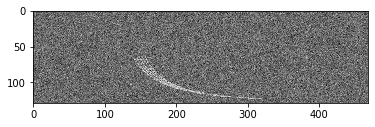

In [28]:
dataset_yolo_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'yolo')
dataset_yolo = DatasetYolo(dataset_yolo_loc, 0.006395061728395062, 0.15503875968992248)
# print(dataset_yolo.get_time_freq_res())
# plt.pcolormesh(dataset_yolo.whistler_D0_sim(0.35,20,3,2,3))
# plt.pcolormesh(dataset_yolo.whistler_sim(0.35,20,3))
# plt.pcolormesh(dataset_yolo.noise_sim(0.35,0.5))
# plt.figure(figsize=(16,4))
# data, labels = dataset_yolo.yolo_sim(An=0.4, D0=50, d0=5, k=5, magnitude=1.4,mean=1.356+0.254,std=0.456+0.056)
# plt.pcolormesh(data, cmap='jet')

# dataset_yolo.yolo_sim_file(An=0.4, D0=50, d0=5, k=5, magnitude=1.4,mean=1.356+0.254,std=0.456+0.056)
plt.imshow(dataset_yolo.load_yolo_file(An=0.4, D0=50, d0=5, k=5, magnitude=1.4,mean=1.356+0.254,std=0.456+0.056), cmap='gray')

# dataset_yolo.generate_yolo()